<Axes: title={'center': 'Sentiment Train'}>

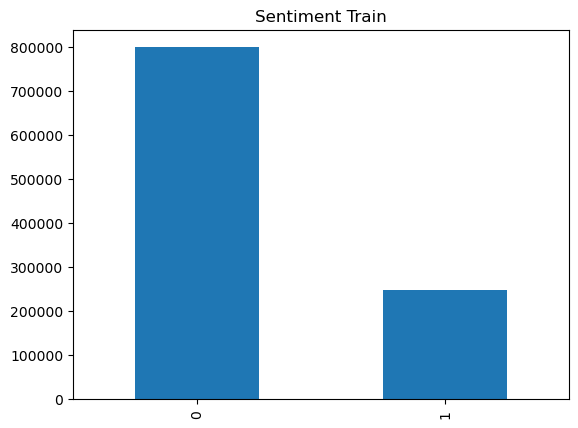

In [1]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt



# plt.style.use('seaborn-v0_8')

#=================== PART I: EXPLORATORY DATA ANALYSIS ===================#

# Visualize Data
df_train = pd.read_csv('../data/train/train.csv')
df_test = pd.read_csv('../data/test/test.csv')

df_train['Sentiment'].value_counts().sort_index().plot(kind='bar', title='Sentiment Train')



In [2]:
# Example text 
example = df_train['Text'].sample(n=1).values[0]
example




'@vivinyvil now i feel bad for all those tea addiction i cause '

In [3]:
import nltk 
from nltk import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import re

#=================== PART II: Text Preprossing  ===================#

def text_preprocessing(df):
    # change to lowercase 
    df['Text'] = df['Text'].apply(str.lower)
    # df_subset.head()

    # remove digits 
    df['Text'] = df['Text'].str.replace('\d+', '', regex=True)
    df.head()

    # decontraction 
    df['Text'] = df['Text'].str.replace(r'won\'t', 'will not', regex=True)
    df['Text'] = df['Text'].str.replace(r'can\'t', 'can not', regex=True)
    df['Text'] = df['Text'].str.replace(r'n\'t', ' not', regex=True)
    df['Text'] = df['Text'].str.replace(r'\'re', ' are', regex=True)
    df['Text'] = df['Text'].str.replace(r'\'s', ' is', regex=True)
    df['Text'] = df['Text'].str.replace(r'\'d', ' would', regex=True)
    df['Text'] = df['Text'].str.replace(r'\'ll', ' will', regex=True)
    df['Text'] = df['Text'].str.replace(r'\'t', ' not', regex=True)
    df['Text'] = df['Text'].str.replace(r'\'ve', ' have', regex=True)
    df['Text'] = df['Text'].str.replace(r'\'m', ' am', regex=True)

    # remove special characters (usernames)
    df['Text'] = df['Text'].str.replace('[^a-z0-9<>]', ' ', regex=True)

    # apply stemming 
    stemmer = SnowballStemmer("english")
    df['Text'] = df['Text'].apply(lambda i: stemmer.stem(i))

    return df






In [4]:
# from gensim.test.utils import common_texts
from gensim.models import Word2Vec
# METHOD 3: Word2Vec
def w2v(df): 
    wordpunct_tokenize = WordPunctTokenizer()
    tokenized_sentence = [wordpunct_tokenize.tokenize(i) for i in df['Text']]
    word2vec_model = Word2Vec(tokenized_sentence, vector_size=100, min_count=1)

    return word2vec_model



In [5]:
import pickle as pkl

# data preprocessing (Store into pkl files)
with open('train.pkl', 'wb') as file:
    df_processed_train = text_preprocessing(df_train)
    pkl.dump(df_processed_train, file)

with open('test.pkl', 'wb') as file:
    df_processed_test = text_preprocessing(df_test)
    pkl.dump(df_processed_test, file)

In [6]:
#=================== PART III AND IV: FEATURE EXTRACTION AND BINARY CLASSIFICATION  ===================#

# Load Data
with open('train.pkl', 'rb') as file:
    df_processed_train = pkl.load(file)

with open('test.pkl', 'rb') as file:
    df_processed_test = pkl.load(file)

       
# display(df_processed_train)
# display(df_processed_test)

# df_processed_test.shape




In [7]:
# Create 50/50 class balance

df_pos = df_processed_train[df_processed_train['Sentiment'] == 1]
df_neg = df_processed_train[df_processed_train['Sentiment'] == 0]

df_pos = df_pos.sample(n=2500, replace=False, random_state=1)
df_neg = df_neg.sample(n=2500, replace=False, random_state=1)

df_train = pd.concat([df_neg, df_pos], axis=0)

In [8]:
# Word2vec to words

# X_train_vec = set(word2vec.wv.index_to_key)
# print(X_train_vec)

In [9]:
# import tensorflow as tf
# # word2vec transformer
# def vec_avg(w2v_vec):
#     vec_avg = []
#     for vector in  w2v_vec:
#         # if vector is not len of 0
#         if vector.size:
#             vec_avg.append(vector.mean(axis=0))
#         # if vect is empyty fill zeros size of model (100)
#         else: 
#             vec_avg.append(np.zeros(100, dtype=float))
#     return vec_avg

# X_w2v_train_avg = vec_avg(word2vec)
# X_w2v_train_avg.shape

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics

# Define models
log_reg = LogisticRegression(max_iter=1000000)
support_vm = svm.SVC()
nb = GaussianNB()
randf = RandomForestClassifier()



In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# Bag of Words testing and training set 

# Feature Extraction for Bag of Words
vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(df_train['Text'])
y_train = df_train['Sentiment']

x_test = vectorizer.transform(df_processed_test['Text'])
y_test = (df_processed_test['Sentiment'])

x_train = x_train.toarray()
x_test = x_test.toarray()

# print(vectorizer.vocabulary_)

In [12]:
# Bag of Words Training models
log_reg.fit(x_train, y_train)
support_vm.fit(x_train, y_train)
nb.fit(x_train, y_train)
randf.fit(x_train, y_train)


RandomForestClassifier()

In [13]:
# Metrics

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def get_metrics(x_test, y_test, classifier, name): 
    #train model

    y_pred = classifier.predict(x_test)
    y_test = y_test.reset_index(drop=True)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    return accuracy, precision, recall



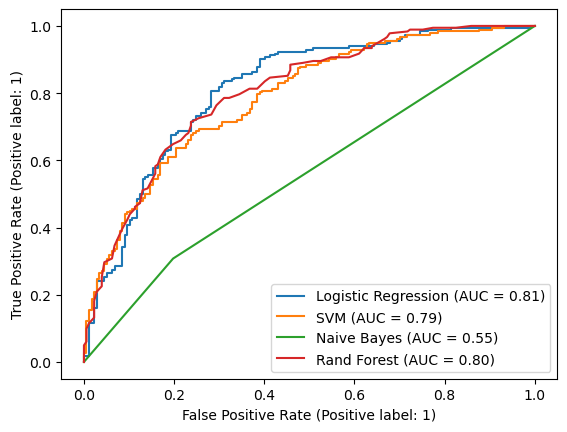

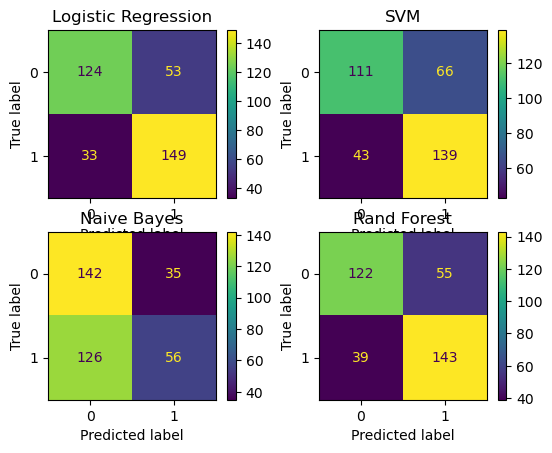

In [14]:
# Metrics for Bag of Words
log_acc, log_prec, log_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=log_reg, name='Logistic Regression')
svm_acc, svm_prec, svm_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=support_vm, name='Support Vector Machine')
nb_acc, nb_prec, nb_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=nb, name='Naive Bayes')
randf_acc, randf_prec, randf_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=randf, name='Random Forest')

# Visualize ROC Curves
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(log_reg, x_test, y_test, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(support_vm, x_test, y_test, ax=ax, name="SVM")
RocCurveDisplay.from_estimator(nb, x_test, y_test, ax=ax, name="Naive Bayes")
RocCurveDisplay.from_estimator(randf, x_test, y_test, ax=ax, name="Rand Forest")

# Visualize 
fig2, ([ax1, ax2], [ax3,ax4]) = plt.subplots(2,2)

ax1.set_title('Logistic Regression')
ax1.grid(False)

ax2.set_title('SVM')
ax2.grid(False)

ax3.set_title('Naive Bayes')
ax3.grid(False)

ax4.set_title('Rand Forest')
ax4.grid(False)




ConfusionMatrixDisplay.from_estimator(log_reg, x_test, y_test, ax=ax1)
ConfusionMatrixDisplay.from_estimator(support_vm, x_test, y_test, ax=ax2)
ConfusionMatrixDisplay.from_estimator(nb, x_test, y_test, ax=ax3)
ConfusionMatrixDisplay.from_estimator(randf, x_test, y_test, ax=ax4)



In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
#================ TRAINING FOR TFIDF ===========================# 
# TFIDF testing and training set 

# Feature Extraction for idf
idf_vectorizer = TfidfVectorizer()

x_train = idf_vectorizer.fit_transform(df_train['Text'])
y_train = df_train['Sentiment']

x_test = idf_vectorizer.transform(df_processed_test['Text'])
y_test = (df_processed_test['Sentiment'])

x_train = x_train.toarray()
x_test = x_test.toarray()

# print(vectorizer.vocabulary_)

In [16]:
# IDF Training models
log_reg.fit(x_train, y_train)
support_vm.fit(x_train, y_train)
nb.fit(x_train, y_train)
randf.fit(x_train, y_train)

RandomForestClassifier()

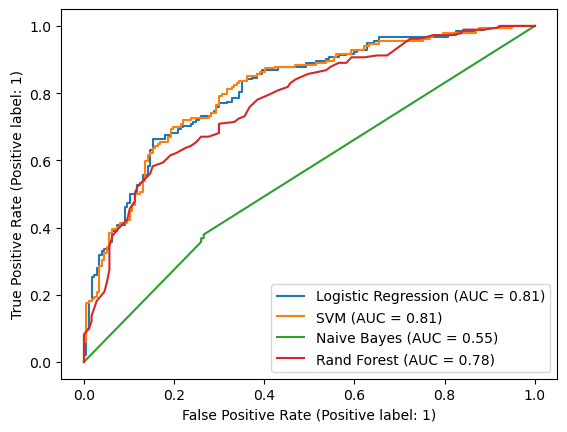

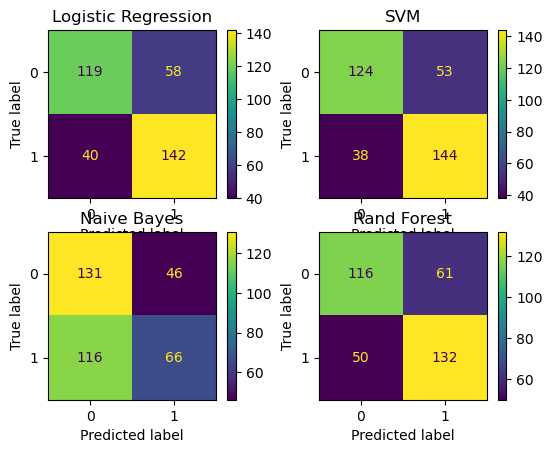

In [17]:
# Metrics for Bag of Words
log_acc, log_prec, log_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=log_reg, name='Logistic Regression')
svm_acc, svm_prec, svm_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=support_vm, name='Support Vector Machine')
nb_acc, nb_prec, nb_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=nb, name='Naive Bayes')
randf_acc, randf_prec, randf_rec = get_metrics(x_test=x_test, y_test=y_test, classifier=randf, name='Random Forest')

# Visualize ROC Curves
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(log_reg, x_test, y_test, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(support_vm, x_test, y_test, ax=ax, name="SVM")
RocCurveDisplay.from_estimator(nb, x_test, y_test, ax=ax, name="Naive Bayes")
RocCurveDisplay.from_estimator(randf, x_test, y_test, ax=ax, name="Rand Forest")

# Visualize 
fig2, ([ax1, ax2], [ax3,ax4]) = plt.subplots(2,2)

ax1.set_title('Logistic Regression')
ax1.grid(False)

ax2.set_title('SVM')
ax2.grid(False)

ax3.set_title('Naive Bayes')
ax3.grid(False)

ax4.set_title('Rand Forest')
ax4.grid(False)




ConfusionMatrixDisplay.from_estimator(log_reg, x_test, y_test, ax=ax1)
ConfusionMatrixDisplay.from_estimator(support_vm, x_test, y_test, ax=ax2)
ConfusionMatrixDisplay.from_estimator(nb, x_test, y_test, ax=ax3)
ConfusionMatrixDisplay.from_estimator(randf, x_test, y_test, ax=ax4)



In [1]:
print('Logistic Regression')
print(classification_report(y_test, log_reg.predict(X_test)))

print('Support Vector Machine')
print(classification_report(y_test, support_vm.predict(X_test)))

print('Naive Bayes')
print(classification_report(y_test, nb.predict(X_test)))

print('Random Forest')
print(classification_report(y_test, randf.predict(X_test)))

Logistic Regression


NameError: name 'classification_report' is not defined